In [34]:
#!pip install monai
#!pip install pydicom
!pip install albumentations 

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [35]:
import pandas as pd
import numpy as np
import pydicom
from PIL import Image as PILImage
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from monai.transforms import Compose, LoadImage, EnsureChannelFirst, RandRotate90, RandFlip, RandZoom, ToTensor
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

## Expected Directory Structure
We expect the following to be in your working directory to run this notebook.

```
.
├── ExploreData.ipynb **This notebook
└── /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/
    ├── test_images/
    │   ├── 1005139/
    │   │   └── 609308237/
    │   │       ├── 1.dcm
    │   │       └── ...
    │   └── ...
    ├── test_series_descriptions.csv
    ├── train_images/
    │   ├── 4003253/
    │   │   └── 702807833/
    │   │       ├── 1.dcm
    │   │       └── ...
    │   └── ...
    ├── train_label_coordinates.csv
    ├── train_series_descriptions.csv
    └── train.csv
```

In [9]:
df_train = pd.read_csv("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv")
df_train_desc = pd.read_csv("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv")
df_train_desc['image_path'] = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/" + df_train_desc['study_id'].astype(str) +"/"+ df_train_desc['series_id'].astype(str) + "/"+ df_train_desc['instance_number'].astype(str) + ".dcm"

train=len(df_train)
desc = len(df_train_desc)
images = len(df_train_desc)


print(train, "Annoatated Images")
print(desc, "Label Coordinates")
print(images, "Image Paths")

1975 Annoatated Images
48692 Label Coordinates
48692 Image Paths


In [16]:
df_train.sample(3)

study_id spinal_canal_stenosis_l1_l2 spinal_canal_stenosis_l2_l3  \
1274  2780669808                 Normal/Mild                 Normal/Mild   
1333  2905685162                 Normal/Mild                 Normal/Mild   
1918  4165566893                 Normal/Mild                 Normal/Mild   

     spinal_canal_stenosis_l3_l4 spinal_canal_stenosis_l4_l5  \
1274                 Normal/Mild                    Moderate   
1333                 Normal/Mild                 Normal/Mild   
1918                 Normal/Mild                 Normal/Mild   

     spinal_canal_stenosis_l5_s1 left_neural_foraminal_narrowing_l1_l2  \
1274                 Normal/Mild                           Normal/Mild   
1333                 Normal/Mild                           Normal/Mild   
1918                 Normal/Mild                           Normal/Mild   

     left_neural_foraminal_narrowing_l2_l3  \
1274                           Normal/Mild   
1333                           Normal/Mild   
1918                           Normal/Mild   

     left_neural_foraminal_narrowing_l3_l4  \
1274                           Normal/Mild   
1333                           Normal/Mild   
1918                           Normal/Mild   

     left_neural_foraminal_narrowing_l4_l5  ...  \
1274                           Normal/Mild  ...   
1333                           Normal/Mild  ...   
1918                           Normal/Mild  ...   

     left_subarticular_stenosis_l1_l2 left_subarticular_stenosis_l2_l3  \
1274                      Normal/Mild                         Moderate   
1333                      Normal/Mild                      Normal/Mild   
1918                      Normal/Mild                      Normal/Mild   

     left_subarticular_stenosis_l3_l4 left_subarticular_stenosis_l4_l5  \
1274                           Severe                           Severe   
1333                      Normal/Mild                      Normal/Mild   
1918                      Normal/Mild                         Moderate   

     left_subarticular_stenosis_l5_s1 right_subarticular_stenosis_l1_l2  \
1274                      Normal/Mild                       Normal/Mild   
1333                      Normal/Mild                       Normal/Mild   
1918                      Normal/Mild                       Normal/Mild   

     right_subarticular_stenosis_l2_l3 right_subarticular_stenosis_l3_l4  \
1274                       Normal/Mild                          Moderate   
1333                       Normal/Mild                       Normal/Mild   
1918                       Normal/Mild                          Moderate   

     right_subarticular_stenosis_l4_l5 right_subarticular_stenosis_l5_s1  
1274                            Severe                       Normal/Mild  
1333                       Normal/Mild                       Normal/Mild  
1918                          Moderate                       Normal/Mild  

[3 rows x 26 columns]

In [11]:
df_train.columns
left_neural_foraminal_narrowing,spina,l_canal_stenosis,right_neural_foraminal_narrowing,left_subarticular_stenosis,right_subarticular_stenosis

Index(['study_id', 'spinal_canal_stenosis_l1_l2',
       'spinal_canal_stenosis_l2_l3', 'spinal_canal_stenosis_l3_l4',
       'spinal_canal_stenosis_l4_l5', 'spinal_canal_stenosis_l5_s1',
       'left_neural_foraminal_narrowing_l1_l2',
       'left_neural_foraminal_narrowing_l2_l3',
       'left_neural_foraminal_narrowing_l3_l4',
       'left_neural_foraminal_narrowing_l4_l5',
       'left_neural_foraminal_narrowing_l5_s1',
       'right_neural_foraminal_narrowing_l1_l2',
       'right_neural_foraminal_narrowing_l2_l3',
       'right_neural_foraminal_narrowing_l3_l4',
       'right_neural_foraminal_narrowing_l4_l5',
       'right_neural_foraminal_narrowing_l5_s1',
       'left_subarticular_stenosis_l1_l2', 'left_subarticular_stenosis_l2_l3',
       'left_subarticular_stenosis_l3_l4', 'left_subarticular_stenosis_l4_l5',
       'left_subarticular_stenosis_l5_s1', 'right_subarticular_stenosis_l1_l2',
       'right_subarticular_stenosis_l2_l3',
       'right_subarticular_stenosis_l3_l4',
 

In [38]:
df_train_melted = df_train.melt(id_vars=['study_id'], var_name='condition_level', value_name='value')

# Split the 'condition_level' column to extract 'condition' and 'level'
df_train_melted[['conditions', 'level']] = df_train_melted['condition_level'].str.rsplit('_', n=2, expand=True).iloc[:, 1:]
df_train_melted['condition'] = df_train_melted['condition_level'].apply(lambda x: '_'.join(x.split('_')[:-2])).str.replace("_"," ").str.title()
df_train_melted['level'] = df_train_melted['conditions'].str.upper() +"/"+ df_train_melted['level'].str.upper()
# Remove the original 'condition_level' column
df_train_melted = df_train_melted.drop(columns=['condition_level', 'conditions'])

# Rename columns for clarity
df_train_melted = df_train_melted.rename(columns={'value': 'severity'})

# Merge the DataFrames on 'study_id', 'level', and 'condition'
df_final = pd.merge(df_train_desc, df_train_melted, on=['study_id', 'level', 'condition'], how='inner')

df_final.sample(5)

study_id   series_id  instance_number  \
20499  1833061198  3267675322               11   
3069    267842058  1293383293                5   
14163  1269542152  3401811950                3   
31149  2763838004   764656002               13   
2959    259346069    82212269               22   

                              condition  level           x           y  \
20499   Left Neural Foraminal Narrowing  L4/L5  257.793103  273.234811   
3069         Left Subarticular Stenosis  L2/L3  161.120536  194.285714   
14163  Right Neural Foraminal Narrowing  L5/S1  199.803170  252.871863   
31149  Right Neural Foraminal Narrowing  L1/L2  129.829529   93.650219   
2959         Left Subarticular Stenosis  L2/L3  163.457732  160.153108   

                                              image_path     severity  
20499  /kaggle/input/rsna-2024-lumbar-spine-degenerat...  Normal/Mild  
3069   /kaggle/input/rsna-2024-lumbar-spine-degenerat...     Moderate  
14163  /kaggle/input/rsna-2024-lumbar-spine-degenerat...  Normal/Mild  
31149  /kaggle/input/rsna-2024-lumbar-spine-degenerat...  Normal/Mild  
2959   /kaggle/input/rsna-2024-lumbar-spine-degenerat...  Normal/Mild

In [33]:
# Directory containing all images
image_dir = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/"

# Get all image paths in the directory
all_image_paths = glob.glob(os.path.join(image_dir, '**', '*.dcm'), recursive=True)

# Convert to a set for faster lookup
annotated_image_paths = set(df_final['image_path'].tolist())

# Identify unannotated images
unannotated_image_paths = [path for path in all_image_paths if path not in annotated_image_paths]

print(f"Total annotated images: {len(annotated_image_paths)}")
print(f"Total unannotated images: {len(unannotated_image_paths)}")

Total annotated images: 24546
Total unannotated images: 122672


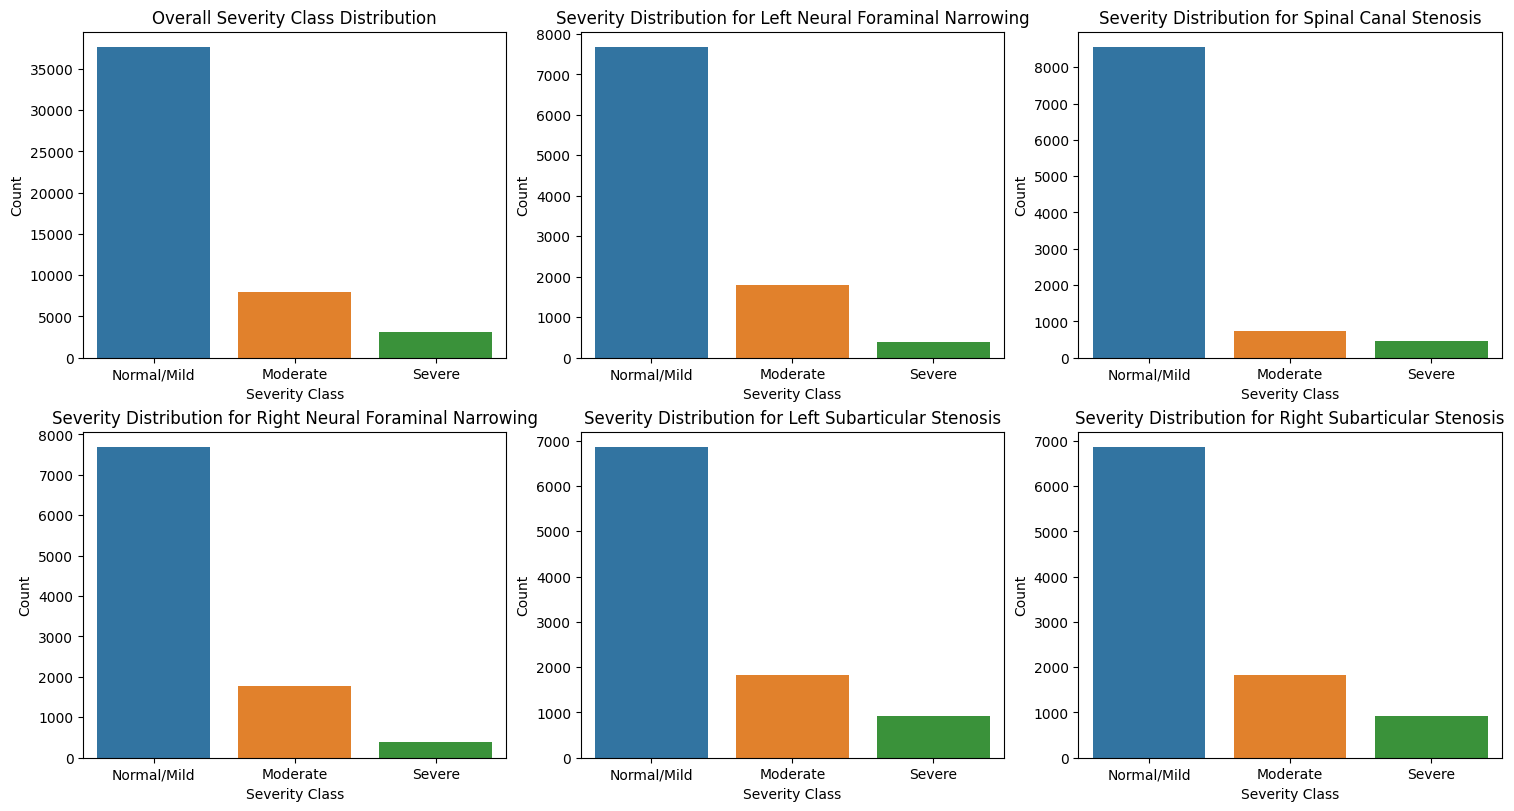

In [29]:
# Define the list of conditions to plot
conditions_to_plot = [
    'Left Neural Foraminal Narrowing',
    'Spinal Canal Stenosis',
    'Right Neural Foraminal Narrowing',
    'Left Subarticular Stenosis',
    'Right Subarticular Stenosis'
]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), constrained_layout=True)

# Plot the overall severity class distribution
sns.countplot(x='severity', data=df_final, order=df_final['severity'].value_counts().index, ax=axes[0, 0])
axes[0, 0].set_title('Overall Severity Class Distribution')
axes[0, 0].set_xlabel('Severity Class')
axes[0, 0].set_ylabel('Count')

# Plot the severity class distribution for each condition
for i, condition in enumerate(conditions_to_plot):
    row, col = divmod(i + 1, 3)  # Start from the second subplot
    condition_data = df_final[df_final['condition'] == condition]
    sns.countplot(x='severity', data=condition_data, order=condition_data['severity'].value_counts().index, ax=axes[row, col])
    axes[row, col].set_title(f'Severity Distribution for {condition}')
    axes[row, col].set_xlabel('Severity Class')
    axes[row, col].set_ylabel('Count')

# Remove any empty subplots (if conditions_to_plot length < 5)
for j in range(i + 2, 6):  # Starting from i+2 because i+1 is the last plot created
    row, col = divmod(j, 3)
    fig.delaxes(axes[row, col])

plt.show()

In [41]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
from tqdm import tqdm
import os

# Define the augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(p=0.5, shift_limit=0.1, scale_limit=0.1, rotate_limit=45),
    A.ColorJitter(p=0.5),
    A.Normalize(),
    ToTensorV2()
])

# Use image paths from the dataframe
annotated_image_paths = df_final['image_path'].tolist()

# Function to augment images
def augment_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to read image: {image_path}")
        return None, False
    try:
        augmented = transform(image=image)
        if 'image' not in augmented:
            print(f"Augmentation failed for image: {image_path}")
            return None, False
        augmented_image = augmented['image']
    except Exception as e:
        print(f"Failed to augment image: {image_path}. Error: {str(e)}")
        return None, False
    return augmented_image, True

# Function to process images in batches
def process_batch(image_paths):
    augmented_images = []
    augmented_paths = []
    for path in image_paths:
        augmented_image, success = augment_image(path)
        if success:
            augmented_images.append(augmented_image)
            augmented_paths.append(path)
    if len(augmented_images) == 0:
        return None, []
    return np.stack(augmented_images), augmented_paths

# Batch processing
batch_size = 32
successful_augmented_paths = []
for i in tqdm(range(0, len(annotated_image_paths), batch_size)):
    batch_paths = annotated_image_paths[i:i + batch_size]
    augmented_images_batch, augmented_paths_batch = process_batch(batch_paths)
    if augmented_images_batch is not None:
        successful_augmented_paths.extend(augmented_paths_batch)
        # Process the augmented images further or save them as needed
        # You can add your additional processing or saving logic here

# Print or log the paths of successfully augmented images
print(f"Successfully augmented {len(successful_augmented_paths)} images.")
print("Example augmented paths:")
for path in successful_augmented_paths[:5]:  # Print first 5 paths for example
    print(path)


  0%|          | 3/1522 [00:00<00:51, 29.61it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/1054713880/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/1054713880/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/1054713880/5.dcm
Faile

  1%|          | 11/1522 [00:00<00:43, 34.38it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/22191399/3687121182/21.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/22191399/3687121182/27.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/22191399/3687121182/29.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/22191399/3687121182/37.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/22191399/3687121182/38.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/22191399/3687121182/45.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/22191399/3687121182/46.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/22191399/37

  1%|          | 15/1522 [00:00<00:51, 29.38it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/52397721/2452297573/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/52397721/2452297573/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/52397721/2452297573/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/52397721/2452297573/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/52397721/2452297573/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/52397721/2770638094/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/52397721/2770638094/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/52397721/277063809

  2%|▏         | 24/1522 [00:00<00:48, 30.75it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/60612428/661972121/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/60612428/661972121/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/60612428/661972121/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/60612428/2349970136/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/60612428/2349970136/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/60612428/2349970136/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/60612428/2349970136/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/60612428/234997013

  2%|▏         | 28/1522 [00:00<00:46, 32.43it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/76438935/2212277614/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/76438935/2212277614/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/76438935/2212277614/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/76438935/2212277614/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/76438935/2212277614/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/76438935/2212277614/23.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/76438935/2212277614/24.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/76438935/332

  2%|▏         | 36/1522 [00:01<00:46, 32.21it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/92565488/1063025652/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/92565488/1063025652/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/92565488/1212091506/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/92565488/1212091506/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/92565488/1212091506/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/92565488/1212091506/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/92565488/1212091506/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/92565488/1955152

  3%|▎         | 44/1522 [00:01<00:45, 32.13it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/107935613/2724788286/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/107935613/2724788286/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/107935613/2724788286/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/107935613/2724788286/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/107935613/2724788286/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/107935613/2724788286/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/107935613/2724788286/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/108348

  3%|▎         | 48/1522 [00:01<00:46, 31.80it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/114899184/1364910156/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/114899184/1364910156/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/114899184/1364910156/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/114899184/1364910156/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/114899184/1364910156/26.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/114899184/1364910156/26.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/114899184/1364910156/36.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1148

  4%|▎         | 56/1522 [00:01<00:46, 31.74it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/140799588/3885989652/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/140799588/3885989652/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/140799588/3885989652/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/142991438/56615998/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/142991438/56615998/16.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/142991438/56615998/22.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/142991438/56615998/22.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/142991438/566

  4%|▍         | 60/1522 [00:01<00:49, 29.77it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/165018059/407148354/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/165018059/407148354/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/165018059/407148354/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/165018059/407148354/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/165018059/407148354/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/165018059/407148354/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/165018059/407148354/23.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/165018059/407

  4%|▍         | 67/1522 [00:02<00:50, 28.54it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/177339056/3869214210/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/177339056/3869214210/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/177339056/3869214210/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/177339056/3869214210/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/178041181/530141745/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/178041181/530141745/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/178041181/530141745/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/17804118

  5%|▍         | 74/1522 [00:02<00:47, 30.33it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/185510290/3800866193/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/185510290/3800866193/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/185510290/3800866193/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/185510290/3800866193/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/185510290/3800866193/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/189160688/2459939517/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/189160688/2459939517/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/18916068

  5%|▌         | 78/1522 [00:02<00:45, 31.61it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/208289456/1491690538/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/208289456/1491690538/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/208289456/1491690538/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/208289456/1491690538/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/208289456/1491690538/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/208289456/2181530405/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/208289456/2181530405/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/208289

  6%|▌         | 86/1522 [00:02<00:44, 32.18it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/218109857/1066112297/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/218109857/1066112297/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/218109857/1066112297/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/218109857/1066112297/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/218109857/1783079607/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/218109857/1783079607/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/218109857/1783079607/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/218109857/1

  6%|▌         | 95/1522 [00:03<00:39, 36.09it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/241354569/3138925392/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/241354569/3138925392/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/241354569/3138925392/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/241354569/3138925392/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/241354569/3138925392/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/241354569/3992815930/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/241354569/3992815930/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/241354

  7%|▋         | 103/1522 [00:03<00:38, 36.64it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/267842058/1293383293/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/267842058/1293383293/17.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/267842058/1293383293/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/267842058/2575571960/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/267842058/2575571960/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/267842058/2575571960/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/267842058/2575571960/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/26784205

  7%|▋         | 107/1522 [00:03<00:43, 32.85it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/287921610/120457103/2.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/287921610/120457103/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/287921610/120457103/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/287921610/120457103/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/287921610/120457103/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/287921610/120457103/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/287921610/120457103/16.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/287921610/12045

  7%|▋         | 111/1522 [00:03<00:48, 29.21it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/305320071/3350746151/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/305320071/3350746151/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/305320071/3350746151/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/305320071/3350746151/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/305320071/3350746151/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/305320071/3350746151/22.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/305320071/3350746151/23.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/30532

  8%|▊         | 119/1522 [00:03<00:46, 30.21it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/314041963/2190516057/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/314041963/2190516057/16.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/314041963/2190516057/16.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/314041963/2190516057/16.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/314041963/2190516057/17.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/314041963/2190516057/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/314041963/3384935415/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/314041

  8%|▊         | 127/1522 [00:04<00:44, 31.69it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/331605392/2248038535/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/331605392/2248038535/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/331605392/2248038535/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/331605392/2248038535/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/331605392/2248038535/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/331605392/2616653576/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/331605392/2616653576/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/331605392

  9%|▊         | 131/1522 [00:04<00:43, 32.16it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/344269999/3024542923/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/344269999/3024542923/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/344297746/2116827468/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/344297746/2116827468/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/344297746/2116827468/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/344297746/2116827468/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/344297746/2541114970/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/34429

  9%|▉         | 140/1522 [00:04<00:37, 36.47it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/375720624/1243311650/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/375720624/1243311650/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/375720624/1243311650/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/375720624/1243311650/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/375720624/1243311650/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/375720624/2223891863/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/375720624/2223891863/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/375720

 10%|▉         | 150/1522 [00:04<00:34, 39.73it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/390498354/3613440209/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/390498354/3613440209/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/390498354/3613440209/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/390498354/3613440209/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/390498354/3613440209/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/390498354/3613440209/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/390498354/3613440209/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/390498354

 10%|█         | 154/1522 [00:04<00:37, 36.11it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/416521027/1537073204/39.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/416521027/1537073204/39.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/416521027/1997849815/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/416521027/1997849815/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/416521027/2597582307/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/416521027/2597582307/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/416521027/2597582307/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/41652102

 11%|█         | 162/1522 [00:05<00:39, 34.18it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/435244060/1527592625/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/435244060/1527592625/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/435244060/1527592625/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/435244060/1527592625/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/435244060/1527592625/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/435244060/1527592625/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/435244060/1527592625/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/435244060

 11%|█         | 170/1522 [00:05<00:38, 35.51it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/450154999/3382678010/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/450154999/3382678010/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/450154999/3382678010/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/450154999/3382678010/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/450154999/3382678010/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/450306455/252911129/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/450306455/252911129/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/450306455/252

 11%|█▏        | 174/1522 [00:05<00:41, 32.18it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/480042730/1448098180/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/480042730/1448098180/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/480042730/1448098180/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/480042730/1448098180/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/480042730/1448098180/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/480042730/1448098180/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/480042730/1448098180/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/480042

 12%|█▏        | 182/1522 [00:05<00:44, 30.13it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/490052995/3004013048/29.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/490052995/3419094630/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/490052995/3419094630/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/490052995/3419094630/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/490052995/3419094630/16.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/490052995/3419094630/17.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/491250714/613508131/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/49125

 12%|█▏        | 186/1522 [00:05<00:42, 31.67it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/511308298/3802564411/21.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/511308298/3802564411/22.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/511308298/3802564411/26.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/511308298/3802564411/27.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/511308298/3802564411/31.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/511308298/3802564411/31.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/511857239/157870521/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/511857

 13%|█▎        | 194/1522 [00:06<00:41, 32.31it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/527598501/3800352180/39.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/527598501/3964135527/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/527598501/3964135527/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/527598501/3964135527/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/527598501/3964135527/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/527598501/3964135527/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/527598501/3964135527/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/527598501

 13%|█▎        | 198/1522 [00:06<00:42, 31.01it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/566404205/4216214352/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/566404205/4216214352/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/566404205/4216214352/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/566404205/4216214352/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/566404205/4216214352/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/566498560/246984709/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/566498560/246984709/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/566498560/246

 14%|█▎        | 206/1522 [00:06<00:45, 29.21it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/594735110/408469134/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/594735110/408469134/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/594735110/408469134/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/594735110/3717729365/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/594735110/3717729365/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/594735110/3717729365/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/594735110/3717729365/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/594735110/3

 14%|█▍        | 213/1522 [00:06<00:43, 29.80it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/607436629/4274490658/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/607436629/4274490658/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/607436629/4274490658/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/607436629/4274490658/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/607436629/4274490658/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/607436629/4274490658/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/607436629/4274490658/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/607436629

 14%|█▍        | 217/1522 [00:06<00:40, 32.22it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/624497208/1805142839/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/624497208/1805142839/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/624497208/1805142839/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/624497208/1805142839/23.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/624497208/2606365715/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/624497208/2606365715/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/624497208/2606365715/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/62449

 15%|█▍        | 225/1522 [00:07<00:40, 31.98it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/638284307/3018926795/23.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/638284307/3018926795/23.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/640323917/1695361344/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/640323917/1695361344/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/640323917/1695361344/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/640323917/1695361344/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/640323917/1695361344/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/640323

 15%|█▌        | 233/1522 [00:07<00:38, 33.60it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/652905669/3585001619/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/652905669/3585001619/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/652905669/3585001619/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/660253947/509359750/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/660253947/509359750/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/660253947/509359750/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/660253947/509359750/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/660253947/50

 16%|█▌        | 237/1522 [00:07<00:43, 29.70it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/677672203/1526555382/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/677672203/1526555382/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/677672203/1526555382/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/677672203/1526555382/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/677672203/1895546738/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/677672203/1895546738/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/677672203/1895546738/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/677672

 16%|█▌        | 245/1522 [00:07<00:42, 30.15it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/684790345/3704367088/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/684790345/3704367088/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/684790345/3704367088/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/684790345/3754787010/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/684790345/3754787010/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/684790345/3754787010/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/684790345/3754787010/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/684790345/3

 16%|█▋        | 249/1522 [00:07<00:40, 31.79it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/701848105/68270346/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/701848105/68270346/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/701848105/68270346/23.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/701848105/68270346/23.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/701848105/68270346/28.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/701848105/68270346/29.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/701848105/759243276/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/701848105/7592432

 17%|█▋        | 258/1522 [00:08<00:35, 35.69it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/719139061/2224217453/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/719139061/2224217453/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/719139061/2224217453/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/719139061/2224217453/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/719139061/2224217453/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/719139061/2224217453/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/719139061/2224217453/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/719139061

 17%|█▋        | 266/1522 [00:08<00:38, 33.00it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/756692789/47136253/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/756692789/2514424284/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/756692789/2514424284/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/756692789/2514424284/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/756692789/2514424284/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/756692789/2514424284/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/756692789/2514424284/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/75669278

 18%|█▊        | 270/1522 [00:08<00:41, 29.96it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/767443105/3736569943/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/767443105/3736569943/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/767443105/3736569943/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/767443105/3736569943/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/767443105/3736569943/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/767443105/3736569943/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/767443105/3736569943/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/767443

 18%|█▊        | 278/1522 [00:08<00:41, 30.25it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/786544183/935806222/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/786544183/935806222/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/786544183/935806222/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/786544183/935806222/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/786544183/935806222/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/786544183/935806222/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/786544183/935806222/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/786544183/935806

 19%|█▊        | 282/1522 [00:08<00:42, 29.10it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/798120215/2208068369/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/798120215/2208068369/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/798120215/2208068369/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/798120215/2208068369/23.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/798120215/2208068369/23.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/798120215/3906969060/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/798120215/3906969060/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/798120

 19%|█▉        | 286/1522 [00:08<00:39, 30.93it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/809072026/2594153114/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/809072026/2594153114/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/809072026/2594153114/26.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/809072026/2594153114/26.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/809072026/2594153114/35.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/809072026/2594153114/35.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/809072026/2594153114/42.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/8090

 19%|█▉        | 293/1522 [00:09<00:44, 27.42it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/824003539/2592406902/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/824003539/3222558629/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/824003539/3222558629/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/824003539/3222558629/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/824003539/3222558629/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/824003539/3222558629/25.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/824003539/3222558629/25.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/8240

 20%|█▉        | 299/1522 [00:09<00:45, 27.09it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/844086813/1739042979/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/844086813/1739042979/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/844086813/1739042979/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/844086813/1739042979/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/844086813/2002179590/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/844086813/2002179590/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/844086813/2002179590/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/8440868

 20%|██        | 306/1522 [00:09<00:41, 29.01it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/864298998/1411579616/31.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/864298998/1411579616/31.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/864298998/1411579616/40.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/864298998/1411579616/40.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/864298998/1411579616/47.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/864298998/1411579616/48.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/864298998/3642768231/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/86429

 20%|██        | 312/1522 [00:09<00:45, 26.82it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/885894528/2509467535/27.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/885894528/2509467535/28.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/885894528/2509467535/34.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/885894528/2509467535/34.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/885894528/2509467535/41.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/885894528/2509467535/41.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/885894528/3303042519/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/88589

 21%|██        | 316/1522 [00:10<00:44, 27.21it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/899435449/2762010587/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/899435449/2762010587/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/899435449/2762010587/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/899435449/2762010587/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/899435449/2762010587/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/899435449/2762010587/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/899435449/2762010587/17.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/8994354

 21%|██▏       | 324/1522 [00:10<00:37, 31.95it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/916362094/3699245246/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/916362094/3699245246/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/916362094/3699245246/26.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/916362094/3699245246/33.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/916362094/3699245246/40.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/916362094/4294540297/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/916362094/4294540297/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/91636

 22%|██▏       | 328/1522 [00:10<00:39, 29.90it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/938749597/4214691328/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/938749597/4214691328/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/938749597/4214691328/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/938749597/4214691328/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/938749597/4214691328/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/938749597/4214691328/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/938749597/4214691328/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/9387495

 22%|██▏       | 336/1522 [00:10<00:40, 29.50it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/947021330/2253416900/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/947021330/2253416900/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/947021330/2253416900/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/947021330/2253416900/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/947021330/2253416900/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/947021330/2253416900/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/947021330/2253416900/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/947021

 22%|██▏       | 340/1522 [00:10<00:42, 27.78it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/959290081/2442517942/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/959290081/2442517942/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/959290081/2442517942/16.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/959290081/2442517942/17.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/959290081/2442517942/17.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/959290081/2520054905/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/959290081/2520054905/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/959290

 23%|██▎       | 346/1522 [00:11<00:45, 25.70it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/972691286/262618940/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/972691286/262618940/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/972691286/3617961459/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/972691286/3617961459/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/972691286/3617961459/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/972691286/3617961459/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/972691286/3617961459/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/972691286/3

 23%|██▎       | 349/1522 [00:11<00:44, 26.48it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/983365930/680927594/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/983365930/680927594/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/983365930/680927594/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/983365930/680927594/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/983365930/751248046/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/983365930/751248046/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/983365930/751248046/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/983365930/7512

 23%|██▎       | 355/1522 [00:11<00:47, 24.52it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/992674144/1576603050/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/992674144/1576603050/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/992674144/1576603050/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/992674144/1576603050/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/992674144/1576603050/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/992674144/1614310972/2.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/992674144/1614310972/2.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/992674144/1

 24%|██▎       | 361/1522 [00:11<00:45, 25.35it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1012375618/352098527/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1012375618/352098527/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1012375618/352098527/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1012375618/352098527/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1012375618/352098527/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1012375618/588002243/2.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1012375618/588002243/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/101237

 24%|██▍       | 364/1522 [00:11<00:44, 26.01it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1028684462/1958018915/21.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1028684462/1958018915/21.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1028684462/1958018915/29.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1028684462/1958018915/32.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1028684462/1958018915/39.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1028684462/1958018915/39.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1028684462/1958018915/44.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_imag

 25%|██▍       | 374/1522 [00:12<00:34, 33.12it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1051198661/3383000137/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1051198661/3383000137/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1051198661/3383000137/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1051198661/3383000137/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1051198661/3383000137/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1051595826/1280894613/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1051595826/1280894613/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1051

 25%|██▌       | 383/1522 [00:12<00:34, 33.10it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1084486898/3897408956/85.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1084486898/3897408956/110.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1084486898/3897408956/110.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1084486898/3897408956/132.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1084486898/3897408956/134.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1085426528/211738165/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1085426528/211738165/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_imag

 25%|██▌       | 388/1522 [00:12<00:32, 35.21it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1095894979/1332065618/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1096630192/2760514784/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1096630192/2760514784/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1096630192/2760514784/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1096630192/2760514784/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1096630192/2760514784/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1096630192/2760514784/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/10

 26%|██▌       | 392/1522 [00:12<00:33, 33.85it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1116588610/1427324525/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1116588610/2561559287/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1116588610/2561559287/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1116588610/2561559287/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1116588610/2561559287/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1116588610/2561559287/23.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1116588610/2561559287/24.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_imag

 26%|██▋       | 400/1522 [00:12<00:38, 29.47it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1125872530/553270249/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1125872530/553270249/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1125872530/553270249/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1125872530/553270249/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1125872530/1069936273/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1125872530/1069936273/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1125872530/1069936273/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1125872

 27%|██▋       | 404/1522 [00:13<00:36, 30.83it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1140848367/3931652094/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1140848367/3931652094/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1140848367/3931652094/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1140848367/3931652094/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1140848367/3931652094/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1140848367/3931652094/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1140988368/1017047203/2.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images

 27%|██▋       | 412/1522 [00:13<00:37, 29.93it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1164861071/2597995868/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1164861071/2597995868/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1164861071/2597995868/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1164861071/2597995868/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1164861071/2597995868/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1164861071/3163330218/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1164861071/3163330218/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images

 27%|██▋       | 416/1522 [00:13<00:35, 31.11it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1176954132/3283776646/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1176954132/3283776646/20.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1176954132/3283776646/21.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1176954132/4025755581/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1176954132/4025755581/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1176954132/4025755581/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1176954132/4025755581/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_imag

 28%|██▊       | 424/1522 [00:13<00:38, 28.22it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1195410745/3558150482/27.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1195410745/3898600587/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1195410745/3898600587/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1195410745/3898600587/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1195410745/3898600587/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1195410745/3898600587/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1196781988/2027038733/2.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_image

 28%|██▊       | 427/1522 [00:13<00:41, 26.48it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1212932624/4275546294/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1212932624/4275546294/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1212932624/4275546294/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1212932624/4275546294/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1212932624/4275546294/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1215498865/268383691/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1215498865/268383691/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/121549

 29%|██▊       | 435/1522 [00:14<00:38, 28.39it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1239697165/2348732293/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1239697165/2348732293/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1239697165/2348732293/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1239697165/2348732293/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1239697165/2348732293/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1245057921/412053118/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1245057921/412053118/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1

 29%|██▉       | 438/1522 [00:14<00:39, 27.67it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1254175796/1469090549/32.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1254175796/1469090549/40.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1254175796/1469090549/42.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1254175796/1469090549/51.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1254175796/1469090549/51.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1254175796/3234241859/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1254175796/3234241859/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images

 29%|██▉       | 445/1522 [00:14<00:37, 28.70it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1266853322/2621060433/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1266853322/2621060433/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1266853322/2621060433/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1266853322/2621060433/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1266853322/2621060433/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1266853322/2621060433/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1266853322/2621060433/20.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images

 30%|██▉       | 452/1522 [00:14<00:37, 28.70it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1277947572/52527640/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1277947572/52527640/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1277947572/1712180007/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1277947572/1712180007/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1277947572/1712180007/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1277947572/1712180007/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1277947572/1712180007/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/127794

 30%|███       | 458/1522 [00:15<00:39, 27.11it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1294500604/3946918675/17.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1294500604/3946918675/17.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1296715983/638163553/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1296715983/638163553/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1296715983/638163553/16.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1296715983/638163553/17.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1296715983/638163553/22.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/129

 30%|███       | 461/1522 [00:15<00:42, 24.83it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1302724340/282863131/23.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1302724340/796169225/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1302724340/796169225/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1302724340/796169225/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1302724340/796169225/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1302724340/796169225/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1302724340/796169225/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/130272434

 30%|███       | 464/1522 [00:15<00:40, 25.85it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1314603564/2650168284/35.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1314603564/2650168284/35.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1314603564/2650168284/41.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1316926688/244665939/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1316926688/244665939/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1316926688/244665939/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1316926688/244665939/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/13169

 31%|███       | 472/1522 [00:15<00:38, 26.99it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1336412861/1127086676/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1336412861/1127086676/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1336412861/1127086676/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1336412861/1127086676/20.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1336412861/1127086676/20.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1336412861/1127086676/26.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1336412861/1127086676/32.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_image

 31%|███▏      | 478/1522 [00:15<00:41, 25.05it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1354411109/3679776577/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1354411109/3679776577/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1354411109/3679776577/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1354411109/3679776577/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1360027517/124253530/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1360027517/124253530/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1360027517/124253530/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/136

 32%|███▏      | 482/1522 [00:15<00:38, 26.92it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1375978793/886132449/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1375978793/886132449/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1375978793/886132449/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1375978793/2674598376/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1375978793/2674598376/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1375978793/2674598376/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1375978793/2674598376/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1375

 32%|███▏      | 489/1522 [00:16<00:35, 29.42it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1387631768/2692567377/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1387631768/2692567377/21.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1388399428/1048222662/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1388399428/1048222662/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1388399428/1048222662/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1388399428/1048222662/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1388399428/1048222662/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_imag

 33%|███▎      | 496/1522 [00:16<00:33, 30.40it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1414872844/3285982057/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1414872844/3285982057/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1414872844/3285982057/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1414872844/3285982057/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1414872844/3285982057/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1414872844/3285982057/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1414872844/3285982057/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/14

 33%|███▎      | 500/1522 [00:16<00:35, 28.50it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1425886222/2725495179/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1425886222/2725495179/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1425886222/2725495179/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1425886222/2725495179/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1425886222/3426276339/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1425886222/3426276339/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1425886222/3426276339/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/142

 33%|███▎      | 506/1522 [00:16<00:39, 25.83it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1436167447/1395541485/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1436167447/1395541485/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1436167447/1395541485/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1436167447/1395541485/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1436167447/1395541485/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1436167447/1395541485/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1436167447/1395541485/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/14

 33%|███▎      | 509/1522 [00:16<00:38, 26.34it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1452809491/598956325/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1452809491/598956325/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1452809491/598956325/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1452809491/598956325/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1452809491/598956325/23.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1452809491/839623753/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1452809491/839623753/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/145280

 34%|███▍      | 517/1522 [00:17<00:36, 27.74it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1461308638/1114122867/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1461308638/1114122867/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1461308638/1114122867/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1461368679/2332227383/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1461368679/2332227383/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1461368679/2332227383/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1461368679/2332227383/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_imag

 34%|███▍      | 524/1522 [00:17<00:35, 28.35it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1476653507/111126135/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1476653507/111126135/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1476653507/111126135/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1476653507/111126135/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1476653507/111126135/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1476653507/111126135/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1476653507/111126135/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/147665350

 35%|███▍      | 527/1522 [00:17<00:38, 26.09it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1504981676/1729312806/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1504981676/1729312806/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1504981676/1729312806/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1504981676/1729312806/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1504981676/1729312806/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1504981676/2390192755/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1504981676/2390192755/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1504

 35%|███▌      | 535/1522 [00:17<00:32, 30.52it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1525013622/1497771265/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1525013622/3130485884/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1525013622/3130485884/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1525013622/3130485884/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1525013622/3130485884/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1525013622/3130485884/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1525013622/3130485884/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/152

 36%|███▌      | 543/1522 [00:18<00:28, 34.19it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1537608176/1647068285/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1537608176/1647068285/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1537608176/1647068285/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1537608176/1647068285/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1537608176/1647068285/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1537608176/1647068285/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1537608176/1647068285/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images

 36%|███▌      | 548/1522 [00:18<00:27, 35.23it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1556537670/2697616588/2.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1556537670/2697616588/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1556537670/2697616588/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1556537670/2697616588/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1556537670/2697616588/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1556537670/2697616588/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1556537670/2697616588/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1

 37%|███▋      | 556/1522 [00:18<00:31, 30.35it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1573051559/1341867671/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1573051559/1341867671/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1573051559/1341867671/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1573051559/1341867671/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1573051559/1341867671/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1573051559/1341867671/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1573051559/1341867671/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images

 37%|███▋      | 560/1522 [00:18<00:35, 27.21it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1590903009/2017924896/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1590903009/2017924896/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1590903009/2017924896/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1590903009/2017924896/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1590903009/2855020288/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1590903009/2855020288/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1590903009/2855020288/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_imag

 37%|███▋      | 568/1522 [00:18<00:31, 30.07it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1612489437/747163858/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1612489437/747163858/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1612489437/747163858/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1612489437/1211656258/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1612489437/1211656258/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1612489437/1211656258/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1612489437/1211656258/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1612489

 38%|███▊      | 572/1522 [00:19<00:29, 32.25it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1641631752/4153003890/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1641631752/4153003890/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1641631752/4153003890/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1641631752/4153003890/23.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1641631752/4153003890/23.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1644309505/1627302771/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1644309505/1627302771/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_imag

 38%|███▊      | 580/1522 [00:19<00:28, 32.58it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1658344327/3974395796/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1658344327/3974395796/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1658344327/3974395796/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1658344327/3974395796/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1658344327/3974395796/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1658344327/3974395796/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1658344327/3974395796/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images

 39%|███▊      | 588/1522 [00:19<00:28, 33.35it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1671291853/4071023438/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1671676307/77368487/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1671676307/77368487/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1671676307/77368487/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1671676307/77368487/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1671676307/77368487/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1671676307/77368487/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1671676307/773

 39%|███▉      | 592/1522 [00:19<00:34, 26.89it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1689123946/3104714333/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1689123946/3104714333/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1689123946/3104714333/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1689123946/3104714333/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1689123946/3104714333/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1689123946/3104714333/23.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1689123946/3104714333/23.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_image

 39%|███▉      | 596/1522 [00:19<00:31, 29.68it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1706437011/1814640980/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1706437011/1814640980/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1706437011/1814640980/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1706437011/1814640980/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1706437011/1814640980/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1706437011/1814640980/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1706437011/4270951758/23.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_image

 40%|███▉      | 604/1522 [00:20<00:30, 29.62it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1722603252/1267494961/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1722603252/1267494961/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1722603252/1267494961/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1722603252/1267494961/24.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1722603252/1267494961/24.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1722603252/4079690004/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1722603252/4079690004/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images

 40%|████      | 612/1522 [00:20<00:29, 30.50it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1742195308/3210956062/2.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1742195308/3210956062/2.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1742195308/3210956062/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1742195308/3210956062/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1742195308/3210956062/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1742195308/3210956062/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1742195308/3210956062/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1

 40%|████      | 616/1522 [00:20<00:30, 29.93it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1752398473/302179181/21.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1752398473/302179181/25.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1752398473/302179181/25.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1752398473/2939979820/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1752398473/2939979820/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1752398473/2939979820/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1752398473/2939979820/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1752

 41%|████      | 620/1522 [00:20<00:28, 31.26it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1767715297/3866933017/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1767715297/3866933017/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1767715297/3866933017/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1768692511/1118892381/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1768692511/1118892381/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1768692511/1118892381/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1768692511/1118892381/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/176

 41%|████      | 627/1522 [00:20<00:32, 27.68it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1781596000/812581384/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1781596000/812581384/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1781596000/812581384/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1781596000/812581384/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1781596000/812581384/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1781596000/812581384/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1781596000/812581384/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/17815960

 41%|████▏     | 631/1522 [00:20<00:29, 29.84it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1794911128/3814020826/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1794911128/3814020826/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1794911128/3814020826/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1794911128/3814020826/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1794911128/3814020826/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1794911128/3814020826/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1794911128/3814020826/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_image

 42%|████▏     | 638/1522 [00:21<00:33, 26.62it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1820866003/3174801643/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1820866003/3174801643/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1820866003/3174801643/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1820866003/3174801643/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1820866003/3174801643/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1820866003/3174801643/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1820866003/3174801643/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images

 42%|████▏     | 641/1522 [00:21<00:37, 23.79it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1829899535/1124062115/42.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1829899535/1124062115/42.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1829899535/1124062115/51.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1829899535/1124062115/51.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1829899535/4115560305/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1829899535/4115560305/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1829899535/4115560305/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/

 42%|████▏     | 644/1522 [00:21<00:42, 20.43it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1839242409/331207842/21.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1839242409/331207842/28.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1839242409/331207842/28.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1839242409/331207842/37.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1839242409/331207842/38.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1839242409/331207842/46.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1839242409/331207842/47.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1839

 43%|████▎     | 651/1522 [00:21<00:36, 24.14it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1855454452/18863551/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1855454452/18863551/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1855454452/18863551/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1855454452/18863551/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1855454452/18863551/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1855454452/207765520/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1855454452/207765520/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1855454452/

 43%|████▎     | 658/1522 [00:22<00:32, 26.43it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1871874877/2798209077/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1871874877/2798209077/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1871874877/2798209077/24.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1871874877/2798209077/24.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1871874877/2798209077/28.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1871874877/2798209077/29.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1871874877/2798209077/34.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_imag

 44%|████▍     | 666/1522 [00:22<00:28, 30.43it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1879696087/3230157587/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1879696087/3230157587/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1879696087/3230157587/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1879696087/3230157587/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1879696087/3230157587/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1879696087/3230157587/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1879696087/3230157587/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1879

 44%|████▍     | 670/1522 [00:22<00:28, 29.73it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1902377008/2945488620/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1902377008/2945488620/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1902377008/2945488620/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1902377008/2945488620/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1902377008/2945488620/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1902377008/2945488620/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1902377008/3170338765/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images

 45%|████▍     | 678/1522 [00:22<00:26, 31.28it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1918947564/626944397/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1918947564/626944397/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1918947564/626944397/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1918947564/626944397/23.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1918947564/2979537941/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1918947564/2979537941/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1918947564/2979537941/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/19189

 45%|████▍     | 682/1522 [00:22<00:28, 29.80it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1953361780/2739412778/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1953361780/3770053014/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1953361780/3770053014/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1953361780/3770053014/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1953361780/3770053014/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1953361780/3770053014/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1956588335/864882267/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1956

 45%|████▌     | 690/1522 [00:23<00:27, 29.77it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1972541574/2167800642/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1972541574/2167800642/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1972541574/2167800642/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1972541574/2167800642/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1972541574/2167800642/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1972541574/2167800642/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1972541574/2167800642/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/19

 46%|████▌     | 694/1522 [00:23<00:26, 31.19it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1992037544/3031555041/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1992037544/3031555041/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1992037544/3031555041/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1992037544/3031555041/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1992037544/3031555041/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1992037544/3031555041/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1992037544/3031555041/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images

 46%|████▌     | 702/1522 [00:23<00:27, 30.27it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2012026632/678673443/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2012026632/678673443/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2012026632/678673443/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2012026632/678673443/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2012026632/678673443/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2012026632/678673443/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2012026632/678673443/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/201202663

 47%|████▋     | 710/1522 [00:23<00:24, 33.45it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2024656887/2277643134/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2024656887/2277643134/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2026420722/2823687618/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2026420722/2823687618/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2026420722/2823687618/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2026420722/2823687618/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2026420722/2823687618/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/20

 47%|████▋     | 715/1522 [00:23<00:22, 35.30it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2041575276/2763270156/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2041575276/2763270156/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2041575276/2763270156/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2041575276/2763270156/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2041575276/2763270156/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2041575276/2763270156/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2041575276/2763270156/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images

 48%|████▊     | 723/1522 [00:24<00:24, 32.83it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2054171343/557729980/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2054171343/557729980/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2054171343/557729980/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2054171343/557729980/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2054171343/557729980/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2054171343/557729980/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2054171343/557729980/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/20541713

 48%|████▊     | 727/1522 [00:24<00:25, 31.39it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2080571489/2002594642/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2080571489/2002594642/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2080571489/2002594642/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2080571489/2002594642/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2080571489/2002594642/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2080571489/2002594642/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2080571489/2002594642/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/20

 48%|████▊     | 736/1522 [00:24<00:23, 32.84it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2108089280/2817103119/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2108089280/2817103119/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2108089280/2817103119/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2108089280/2817103119/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2108089280/2817103119/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2108089280/2817103119/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2108089280/2817103119/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/

 49%|████▉     | 745/1522 [00:24<00:21, 35.93it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2133270441/2008819524/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2133270441/2008819524/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2133270441/3680457452/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2133270441/3680457452/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2133270441/3680457452/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2133270441/3680457452/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2133270441/3680457452/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2

 49%|████▉     | 749/1522 [00:24<00:21, 35.97it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2148339078/3257081508/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2148339078/3257081508/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2148339078/3257081508/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2148339078/3257081508/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2148339078/3257081508/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2149501488/504085824/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2149501488/504085824/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2

 50%|████▉     | 757/1522 [00:25<00:20, 36.82it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2171820085/2186841143/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2171820085/2186841143/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2171820085/2186841143/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2171820085/4083407177/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2171820085/4083407177/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2171820085/4083407177/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2171820085/4083407177/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2

 50%|█████     | 765/1522 [00:25<00:20, 37.11it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2196440863/2984817530/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2196440863/2984817530/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2196440863/2984817530/16.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2196440863/2984817530/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2196440863/2984817530/24.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2196440863/4085998543/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2196440863/4085998543/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/

 51%|█████     | 774/1522 [00:25<00:18, 39.39it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2221449368/1899387549/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2221449368/1899387549/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2221449368/1899387549/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2221449368/1899387549/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2221449368/1899387549/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2221449368/1899387549/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2229950158/716201485/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images

 51%|█████▏    | 782/1522 [00:25<00:19, 37.56it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2247118504/2785977916/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2247118504/4258614205/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2247118504/4258614205/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2247118504/4258614205/26.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2247118504/4258614205/26.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2247118504/4258614205/32.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2247118504/4258614205/33.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_imag

 52%|█████▏    | 790/1522 [00:25<00:20, 35.19it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2262987632/59994070/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2262987632/59994070/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2262987632/59994070/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2262987632/59994070/20.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2262987632/1836670441/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2262987632/1836670441/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2262987632/1836670441/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/22629876

 52%|█████▏    | 794/1522 [00:26<00:21, 33.86it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2280737054/2003527877/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2280737054/2003527877/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2280737054/2003527877/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2280737054/2003527877/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2280737054/2483594361/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2280737054/2483594361/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2280737054/2483594361/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/

 53%|█████▎    | 803/1522 [00:26<00:18, 37.97it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2297295777/2376943158/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2297295777/4161607083/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2297295777/4161607083/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2297295777/4161607083/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2297295777/4161607083/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2297295777/4161607083/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2297295777/4161607083/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/229

 53%|█████▎    | 812/1522 [00:26<00:20, 35.11it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2326232647/66196614/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2326232647/66196614/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2326232647/66196614/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2326232647/66196614/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2326232647/66196614/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2326232647/1227337927/20.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2326232647/1227337927/20.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2326232

 54%|█████▎    | 816/1522 [00:26<00:19, 35.33it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2338627393/1302788818/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2338627393/1302788818/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2338627393/1302788818/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2338627393/1302788818/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2338627393/1302788818/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2338627393/1302788818/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2338627393/1302788818/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/23

 54%|█████▍    | 820/1522 [00:26<00:24, 28.89it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2357870240/1367836053/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2357870240/1367836053/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2357870240/1367836053/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2357870240/1367836053/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2357870240/1367836053/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2357870240/1367836053/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2357870240/1446524665/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_image

 54%|█████▍    | 828/1522 [00:27<00:23, 29.42it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2364535593/2410911166/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2364535593/2410911166/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2364535593/2410911166/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2364535593/2410911166/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2364535593/2410911166/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2364535593/2410911166/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2364535593/2410911166/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/23

 55%|█████▍    | 832/1522 [00:27<00:24, 27.98it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2386338288/718813742/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2386338288/718813742/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2386338288/718813742/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2386338288/718813742/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2386338288/718813742/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2386338288/2109530412/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2386338288/2109530412/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2386

 55%|█████▌    | 840/1522 [00:27<00:21, 32.10it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2397650165/2352869800/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2397650165/2352869800/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2397650165/2352869800/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2397650165/2352869800/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2397650165/2352869800/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2397650165/2352869800/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2399492744/1067589900/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images

 56%|█████▌    | 849/1522 [00:27<00:18, 36.66it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2427774074/751625406/26.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2427774074/751625406/26.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2427774074/751625406/34.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2427774074/751625406/34.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2427774074/751625406/39.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2427774074/751625406/39.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2427774074/2241702571/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2427

 56%|█████▋    | 857/1522 [00:28<00:20, 33.17it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2444340715/767671686/23.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2444340715/1598245081/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2444340715/1598245081/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2444340715/1598245081/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2444340715/1598245081/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2444340715/1598245081/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2444340715/1598245081/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/244

 57%|█████▋    | 861/1522 [00:28<00:19, 33.79it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2466046363/1354590721/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2466046363/1354590721/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2466046363/1354590721/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2466046363/1354590721/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2466046363/1354590721/23.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2466046363/1411325803/2.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2466046363/1411325803/2.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2

 57%|█████▋    | 870/1522 [00:28<00:18, 35.79it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2485173539/2767873378/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2485173539/2767873378/26.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2485173539/2767873378/27.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2485173539/2767873378/34.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2485173539/2767873378/35.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2485173539/2767873378/40.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2485173539/2767873378/41.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_imag

 58%|█████▊    | 878/1522 [00:28<00:17, 36.60it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2498439772/2257949264/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2498439772/2257949264/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2498439772/2257949264/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2498439772/2257949264/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2498439772/2257949264/22.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2498439772/2257949264/22.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2498439772/2257949264/30.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images

 58%|█████▊    | 883/1522 [00:28<00:16, 38.27it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2513871828/1772447605/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2513871828/1772447605/20.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2513871828/1772447605/21.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2515979951/1049520788/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2515979951/1049520788/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2515979951/1049520788/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2515979951/1049520788/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2

 59%|█████▊    | 892/1522 [00:28<00:16, 38.29it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2538919007/716901061/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2538919007/716901061/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2538919007/716901061/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2538919007/716901061/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2538919007/716901061/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2538919007/716901061/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2538919007/716901061/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/253891900

 59%|█████▉    | 900/1522 [00:29<00:18, 33.37it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2556699336/3822593859/23.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2556699336/3822593859/23.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2556699336/3822593859/28.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2556699336/3822593859/28.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2556699336/3822593859/33.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2556699336/3822593859/33.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2557856398/3170818407/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_image

 59%|█████▉    | 904/1522 [00:29<00:19, 31.44it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2568819355/4223104020/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2568819355/4223104020/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2568819355/4223104020/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2569123363/1127777078/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2569123363/1127777078/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2569123363/1127777078/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2569123363/1127777078/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2

 60%|█████▉    | 912/1522 [00:29<00:18, 32.90it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2586348643/3614626557/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2586348643/3614626557/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2586348643/3614626557/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2586348643/3614626557/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2586348643/3614626557/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2586348643/3614626557/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2586348643/3614626557/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/25

 60%|██████    | 916/1522 [00:29<00:19, 31.26it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2603988517/3961762269/2.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2603988517/3961762269/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2603988517/3961762269/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2603988517/3961762269/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2603988517/3961762269/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2603988517/3961762269/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2603988517/3961762269/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/

 61%|██████    | 924/1522 [00:30<00:19, 30.76it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2615694902/1637248207/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2615694902/1637248207/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2615694902/1637248207/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2615694902/1637248207/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2615694902/1637248207/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2615694902/2448339309/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2615694902/2448339309/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/26

 61%|██████    | 928/1522 [00:30<00:19, 30.46it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2624498059/2387647497/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2624498059/2488822988/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2624498059/2488822988/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2624498059/2488822988/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2624498059/2488822988/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2624498059/2488822988/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2624498059/2488822988/20.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images

 61%|██████    | 932/1522 [00:30<00:19, 30.37it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2649306672/2846240361/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2649306672/3373246115/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2649306672/3373246115/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2649306672/3373246115/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2649306672/3373246115/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2649306672/3373246115/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2649306672/3373246115/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/26

 62%|██████▏   | 940/1522 [00:30<00:20, 27.85it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2661101390/3441968837/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2661101390/3441968837/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2661101390/3441968837/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2661101390/3441968837/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2661101390/3441968837/22.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2661101390/3441968837/22.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2661178959/1282279554/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_imag

 62%|██████▏   | 944/1522 [00:30<00:19, 29.58it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2683615288/1060438383/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2683615288/1060438383/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2683615288/1060438383/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2683615288/1060438383/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2683615288/1060438383/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2683615288/1060438383/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2683615288/2553586806/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images

 62%|██████▏   | 951/1522 [00:30<00:20, 27.47it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2696451534/1846537274/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2696451534/1846537274/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2696451534/1846537274/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2696451534/3920672636/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2696451534/3920672636/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2696451534/3920672636/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2696451534/3920672636/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2

 63%|██████▎   | 959/1522 [00:31<00:18, 30.46it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2719549572/2374987445/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2719549572/2374987445/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2719549572/2374987445/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2719549572/2374987445/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2719549572/2539188667/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2719549572/2539188667/21.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2719549572/2539188667/21.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_imag

 63%|██████▎   | 963/1522 [00:31<00:18, 30.16it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2732830741/1227496985/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2732830741/1227496985/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2732830741/1227496985/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2732830741/1227496985/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2732830741/1227496985/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2732830741/1227496985/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2732830741/1227496985/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/

 64%|██████▍   | 971/1522 [00:31<00:17, 32.03it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2746735779/575126472/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2751433125/357680961/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2751433125/357680961/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2751433125/357680961/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2751433125/357680961/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2751433125/357680961/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2751433125/2073214972/2.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/275143312

 64%|██████▍   | 979/1522 [00:31<00:17, 31.35it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2763838004/764656002/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2763838004/764656002/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2763838004/764656002/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2763838004/764656002/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2763838004/764656002/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2763838004/764656002/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2763838004/764656002/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2763838

 65%|██████▍   | 983/1522 [00:31<00:17, 31.31it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2780118855/1306636789/1.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2780118855/1306636789/2.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2780118855/1306636789/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2780118855/1306636789/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2780118855/1306636789/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2780118855/1306636789/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2780118855/1306636789/16.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2

 65%|██████▌   | 991/1522 [00:32<00:17, 30.30it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2794265026/355811520/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2794265026/355811520/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2794265026/355811520/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2794265026/2051065282/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2794265026/2051065282/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2794265026/2051065282/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2794265026/2051065282/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2794

 65%|██████▌   | 996/1522 [00:32<00:16, 32.53it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2802584821/3180237615/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2802584821/3180237615/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2802584821/3180237615/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2802584821/3180237615/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2802584821/3180237615/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2802584821/3242266027/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2802584821/3242266027/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2802

 66%|██████▌   | 1003/1522 [00:32<00:18, 28.33it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2813339656/4212253856/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2814100617/2010827534/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2814100617/2010827534/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2814100617/2010827534/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2814100617/2010827534/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2814100617/2010827534/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2814100617/2010827534/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/28

 66%|██████▌   | 1006/1522 [00:32<00:19, 26.00it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2830065820/1021668429/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2830065820/1021668429/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2830065820/1021668429/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2830065820/1021668429/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2830065820/1021668429/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2830065820/3243602987/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2830065820/3243602987/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images

 67%|██████▋   | 1017/1522 [00:33<00:13, 36.51it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2851207875/3833687077/17.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2851207875/3833687077/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2851207875/3938060966/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2851207875/3938060966/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2851207875/3938060966/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2851207875/3938060966/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2851207875/3938060966/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images

 67%|██████▋   | 1027/1522 [00:33<00:12, 40.97it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2881985242/3851057735/38.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2881985242/3851057735/46.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2881985242/3851057735/46.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2881985242/4289986230/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2881985242/4289986230/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2881985242/4289986230/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2881985242/4289986230/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2

 68%|██████▊   | 1032/1522 [00:33<00:12, 39.26it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2906351586/2866703066/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2907745008/1317312291/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2907745008/1317312291/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2907745008/1317312291/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2907745008/1809056192/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2907745008/1809056192/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2907745008/1809056192/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2907

 68%|██████▊   | 1037/1522 [00:33<00:14, 32.92it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2918963439/3907000201/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2918963439/3907000201/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2918963439/3907000201/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2918963439/3907000201/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2918963439/3907000201/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2920127450/783193444/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2920127450/783193444/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2

 69%|██████▊   | 1045/1522 [00:33<00:14, 34.02it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2938658366/2929023438/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2938658366/2929023438/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2938658366/2929023438/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2938658366/2929023438/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2938658366/2929023438/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2938658366/2929023438/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2938658366/3668709075/2.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images

 69%|██████▉   | 1054/1522 [00:34<00:13, 35.75it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2959123241/3260791894/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2959123241/3260791894/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2959123241/4091200275/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2959123241/4091200275/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2959123241/4091200275/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2959123241/4091200275/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2959123241/4091200275/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_imag

 70%|██████▉   | 1062/1522 [00:34<00:12, 35.68it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2986835162/2483725214/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2986835162/2483725214/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2986835162/2483725214/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2986835162/2483725214/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2986835162/2483725214/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2988180557/1155277136/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2988180557/1155277136/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2988

 70%|███████   | 1070/1522 [00:34<00:12, 36.60it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3012426601/606874143/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3012426601/606874143/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3012426601/606874143/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3012426601/606874143/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3012426601/606874143/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3012426601/606874143/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3012426601/606874143/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/30124266

 71%|███████   | 1074/1522 [00:34<00:13, 32.61it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3029953735/3791383775/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3029953735/3791383775/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3029953735/3791383775/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3029953735/3791383775/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3029953735/3791383775/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3029953735/3791383775/16.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3030051271/2141431060/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images

 71%|███████   | 1083/1522 [00:34<00:11, 36.59it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3046761065/813201682/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3046761065/813201682/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3046761065/813201682/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3046761065/813201682/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3046761065/813201682/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3046761065/813201682/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3046761065/813201682/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/304676106

 72%|███████▏  | 1091/1522 [00:35<00:11, 35.97it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3074144108/845353263/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3074144108/845353263/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3074144108/845353263/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3074144108/845353263/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3074144108/845353263/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3074144108/845353263/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3074144108/845353263/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3074144108/

 72%|███████▏  | 1095/1522 [00:35<00:12, 33.01it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3097937416/3394432191/16.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3098945529/514312570/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3098945529/514312570/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3098945529/514312570/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3098945529/514312570/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3098945529/514312570/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3098945529/3524446760/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/30989455

 72%|███████▏  | 1103/1522 [00:35<00:12, 34.67it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3116585926/666973277/25.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3116585926/666973277/32.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3116585926/666973277/32.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3116585926/3043780434/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3116585926/3043780434/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3116585926/3043780434/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3116585926/3043780434/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3116

 73%|███████▎  | 1111/1522 [00:35<00:11, 36.37it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3138807119/880894888/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3138807119/880894888/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3138807119/880894888/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3138807119/880894888/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3138807119/880894888/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3138807119/880894888/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3138807119/880894888/20.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/31388071

 74%|███████▎  | 1119/1522 [00:35<00:10, 37.33it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3156269631/4030602643/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3156269631/4030602643/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3156269631/4030602643/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3156269631/4030602643/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3156269631/4030602643/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3156269631/4030602643/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3156269631/4030602643/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_imag

 74%|███████▍  | 1123/1522 [00:36<00:12, 32.44it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3167888497/3945806844/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3167888497/3945806844/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3167888497/3945806844/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3167888497/3945806844/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3167888497/3945806844/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3167888497/3945806844/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3168755174/3241932744/2.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/31

 74%|███████▍  | 1127/1522 [00:36<00:14, 27.78it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3187325767/1690665996/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3187325767/1690665996/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3187325767/1690665996/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3187325767/1690665996/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3187325767/1690665996/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3187325767/1690665996/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3187325767/1690665996/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/31

 75%|███████▍  | 1135/1522 [00:36<00:12, 30.98it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3201135301/1180350988/24.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3201135301/1180350988/32.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3201135301/1180350988/33.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3201135301/1180350988/43.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3201135301/1180350988/43.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3201694970/1433639752/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3201694970/1433639752/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images

 75%|███████▍  | 1139/1522 [00:36<00:13, 29.04it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3214034020/3543990744/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3214034020/3543990744/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3214034020/3543990744/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3214034020/3543990744/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3214034020/3543990744/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3214034020/3543990744/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3214034020/3613559885/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3

 75%|███████▌  | 1147/1522 [00:36<00:11, 32.51it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3231592574/1450569374/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3231592574/1450569374/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3231592574/1450569374/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3231592574/1450569374/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3231592574/1924567927/2.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3231592574/1924567927/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3231592574/1924567927/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3231

 76%|███████▌  | 1155/1522 [00:37<00:11, 31.92it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3242507143/4243001764/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3242507143/4243001764/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3242507143/4243001764/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3242507143/4243001764/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3242507143/4243001764/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3242507143/4243001764/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3242507143/4243001764/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images

 76%|███████▋  | 1163/1522 [00:37<00:11, 31.83it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3271808223/3989329750/30.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3271808223/3989329750/30.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3271808223/3989329750/40.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3271808223/3989329750/40.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3271808223/3989329750/49.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3271808223/3989329750/49.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3274262895/84036888/2.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/

 77%|███████▋  | 1167/1522 [00:37<00:10, 33.90it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3293419987/2911714765/26.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3293419987/2911714765/35.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3293419987/2911714765/35.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3293419987/2911714765/45.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3293419987/2911714765/45.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3293419987/2911714765/55.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3293419987/2911714765/55.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_imag

 77%|███████▋  | 1175/1522 [00:37<00:11, 30.67it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3304253168/540806464/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3304253168/540806464/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3304253168/540806464/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3304253168/540806464/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3304253168/540806464/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3304253168/540806464/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3304253168/540806464/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/330425316

 77%|███████▋  | 1179/1522 [00:37<00:10, 31.77it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3319644132/157107762/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3319644132/157107762/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3319644132/157107762/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3319644132/157107762/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3319644132/157107762/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3319644132/2455759028/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3319644132/2455759028/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3319644

 78%|███████▊  | 1187/1522 [00:38<00:10, 31.40it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3331954682/2891110323/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3332550698/760889960/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3332550698/760889960/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3332550698/760889960/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3332550698/760889960/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3332550698/760889960/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3332550698/931234193/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/333255069

 78%|███████▊  | 1192/1522 [00:38<00:09, 33.37it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3340993109/2269691905/27.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3340993109/2269691905/27.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3340993109/2269691905/35.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3340993109/2269691905/35.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3340993109/2269691905/41.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3340993109/2269691905/42.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3341858614/2009354819/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_imag

 79%|███████▉  | 1200/1522 [00:38<00:09, 32.41it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3362964060/818865502/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3362964060/818865502/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3362964060/818865502/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3362964060/818865502/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3362964060/1728258576/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3362964060/1728258576/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3362964060/1728258576/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3362

 79%|███████▉  | 1204/1522 [00:38<00:10, 29.18it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3390414227/2680277484/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3390414227/2680277484/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3390414227/2680277484/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3390414227/2680277484/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3390414227/2680277484/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3390414227/3722090786/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3390414227/3722090786/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3390

 80%|███████▉  | 1212/1522 [00:38<00:09, 32.07it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3421079924/3511164282/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3421079924/3511164282/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3421079924/3511164282/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3421079924/3511164282/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3421079924/3511164282/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3421079924/3511164282/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3421079924/3511164282/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/34

 80%|████████  | 1220/1522 [00:39<00:09, 31.99it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3429409220/2537557169/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3429409220/2537557169/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3429409220/2537557169/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3429409220/2537557169/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3429409220/2985427133/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3429409220/2985427133/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3429409220/2985427133/24.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_imag

 81%|████████  | 1229/1522 [00:39<00:08, 35.48it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3456650246/302519355/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3456650246/302519355/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3456650246/302519355/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3456650246/302519355/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3456650246/302519355/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3456650246/368345857/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3456650246/368345857/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3456

 81%|████████  | 1233/1522 [00:39<00:08, 33.75it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3477102602/2770987099/25.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3477102602/2770987099/25.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3477102602/2770987099/31.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3477102602/2770987099/32.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3477102602/4028877683/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3477102602/4028877683/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3477102602/4028877683/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/

 82%|████████▏ | 1241/1522 [00:39<00:08, 33.59it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3485457199/2652956268/1.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3485457199/2652956268/2.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3485457199/2652956268/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3485457199/2652956268/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3485457199/2652956268/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3485457199/2652956268/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3485457199/2652956268/16.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3

 82%|████████▏ | 1245/1522 [00:39<00:08, 32.21it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3493057494/1621484060/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3493057494/1621484060/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3493057494/1621484060/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3493057494/1621484060/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3493057494/1621484060/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3493057494/2117991482/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3493057494/2117991482/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/34

 82%|████████▏ | 1254/1522 [00:40<00:07, 36.29it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3515641631/3168174388/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3515641631/4119560068/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3515641631/4119560068/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3515641631/4119560068/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3515641631/4119560068/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3521159632/2238648179/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3521159632/2238648179/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/352

 83%|████████▎ | 1262/1522 [00:40<00:07, 36.02it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3532709160/3813111527/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3532709160/3813111527/17.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3532709160/3813111527/17.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3532709160/3813111527/21.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3532709160/3813111527/22.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3534804406/1529113419/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3534804406/1529113419/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images

 83%|████████▎ | 1270/1522 [00:40<00:07, 34.89it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3549949167/3354221034/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3549949167/3354221034/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3549949167/3354221034/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3549949167/3354221034/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3549949167/3620633769/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3549949167/3620633769/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3549949167/3620633769/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/

 84%|████████▎ | 1274/1522 [00:40<00:07, 35.19it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3563559233/2800437838/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3563559233/2800437838/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3563792362/1054822047/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3563792362/1054822047/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3563792362/1054822047/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3563792362/1054822047/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3563792362/1054822047/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/35

 84%|████████▍ | 1282/1522 [00:40<00:07, 33.78it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3583858507/2423728877/16.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3583858507/2423728877/20.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3583858507/2423728877/20.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3583858507/2476869197/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3583858507/2476869197/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3583858507/2476869197/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3583858507/2476869197/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3

 84%|████████▍ | 1286/1522 [00:41<00:07, 29.56it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3612685875/3633398846/38.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3612685875/3633398846/42.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3612685875/3633398846/43.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3616319996/1336727811/2.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3616319996/1336727811/2.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3616319996/1336727811/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3616319996/1336727811/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3

 85%|████████▍ | 1293/1522 [00:41<00:08, 26.35it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3635664607/2309179727/21.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3635664607/2309179727/25.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3635664607/2309179727/26.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3635664607/3876939067/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3635664607/3876939067/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3635664607/3876939067/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3635664607/3876939067/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3

 85%|████████▌ | 1297/1522 [00:41<00:08, 27.94it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3647150026/2172999729/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3647150026/2172999729/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3647150026/2172999729/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3647150026/2172999729/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3647150026/2172999729/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3647150026/2172999729/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3647150026/2172999729/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/

 86%|████████▌ | 1303/1522 [00:41<00:07, 27.96it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3668205319/3892299912/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3668205319/3892299912/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3668205319/3892299912/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3674684193/681523745/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3674684193/681523745/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3674684193/681523745/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3674684193/681523745/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3

 86%|████████▌ | 1311/1522 [00:41<00:07, 29.20it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3687214038/4113788510/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3687214038/4113788510/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3687214038/4113788510/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3687214038/4113788510/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3687214038/4113788510/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3687214038/4113788510/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3687214038/4113788510/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3

 86%|████████▋ | 1314/1522 [00:42<00:07, 28.00it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3701224868/527018024/47.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3701224868/527018024/47.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3701224868/527018024/56.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3701224868/527018024/56.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3701224868/3763896068/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3701224868/3763896068/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3701224868/3763896068/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3

 87%|████████▋ | 1322/1522 [00:42<00:07, 27.54it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3718047621/4184383494/39.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3718047621/4184383494/48.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3718047621/4184383494/49.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3718047621/4184383494/56.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3718047621/4184383494/56.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3719530586/194470896/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3719530586/194470896/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3

 87%|████████▋ | 1326/1522 [00:42<00:06, 29.40it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3731783147/863252428/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3731783147/863252428/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3731783147/863252428/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3731783147/863252428/23.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3731783147/917686996/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3731783147/917686996/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3731783147/917686996/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3731783

 88%|████████▊ | 1334/1522 [00:42<00:05, 33.29it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3745670967/615061872/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3745670967/615061872/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3745670967/615061872/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3745670967/615061872/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3745670967/615061872/24.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3745670967/615061872/24.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3745670967/615061872/32.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/374567

 88%|████████▊ | 1343/1522 [00:42<00:04, 36.04it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3771340895/3977396907/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3771340895/3977396907/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3771340895/3977396907/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3771340895/3977396907/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3771340895/3977396907/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3771340895/3977396907/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3771340895/3977396907/18.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3

 89%|████████▉ | 1351/1522 [00:43<00:04, 35.07it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3817394595/990175634/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3817394595/990175634/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3817394595/990175634/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3817394595/990175634/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3817394595/990175634/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3817394595/990175634/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3817394595/2770051674/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3817

 89%|████████▉ | 1355/1522 [00:43<00:05, 29.19it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3832728523/2593614487/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3832728523/2593614487/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3832728523/2593614487/25.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3832728523/2593614487/25.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3832728523/2593614487/32.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3832728523/2593614487/32.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3832728523/3224695688/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_image

 89%|████████▉ | 1359/1522 [00:43<00:05, 29.39it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3839670742/2482280239/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3839670742/2482280239/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3839670742/2482280239/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3839670742/3554172667/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3839670742/3554172667/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3839670742/3554172667/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3839670742/3554172667/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3839

 90%|████████▉ | 1363/1522 [00:43<00:06, 25.64it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3853089836/43123927/21.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3853089836/43123927/21.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3853089836/43123927/28.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3853089836/43123927/29.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3853089836/43123927/36.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3853089836/43123927/36.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3853089836/43123927/45.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3853089836/

 90%|█████████ | 1370/1522 [00:43<00:05, 27.35it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3865855500/291460631/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3865855500/291460631/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3865855500/291460631/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3865855500/291460631/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3865855500/291460631/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3865855500/291460631/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3865855500/291460631/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/386585550

 90%|█████████ | 1377/1522 [00:44<00:05, 28.94it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3873246148/641885340/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3873246148/641885340/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3873246148/641885340/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3873246148/641885340/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3873246148/641885340/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3873246148/641885340/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3873246148/641885340/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/387324

 91%|█████████ | 1385/1522 [00:44<00:04, 32.70it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3883329784/2484976393/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3883329784/2484976393/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3883329784/2484976393/20.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3883329784/2484976393/21.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3883329784/2484976393/29.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3883329784/2484976393/29.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3883329784/2484976393/37.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_imag

 92%|█████████▏| 1393/1522 [00:44<00:03, 33.33it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3899311713/2176999710/23.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3899311713/2176999710/23.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3899311713/3143836627/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3899311713/3143836627/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3899311713/3143836627/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3899311713/3143836627/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3899311713/3143836627/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/38

 92%|█████████▏| 1398/1522 [00:44<00:03, 35.02it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3922074884/3753272699/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3922074884/3753272699/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3922074884/3753272699/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3922074884/3753272699/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3922074884/3753272699/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3922074884/3753272699/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3922074884/3753272699/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/39

 92%|█████████▏| 1406/1522 [00:44<00:03, 34.33it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3946466534/3226146722/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3946466534/3226146722/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3946466534/3226146722/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3946466534/3226146722/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3946466534/3226146722/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3946466534/3226146722/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3946466534/3226146722/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images

 93%|█████████▎| 1414/1522 [00:45<00:03, 34.87it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3966998094/300164688/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3966998094/300164688/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3966998094/300164688/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3966998094/300164688/23.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3966998094/2812657450/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3966998094/2812657450/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3966998094/2812657450/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/396

 93%|█████████▎| 1418/1522 [00:45<00:02, 35.84it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3985606537/2590599310/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3985606537/2590599310/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3985606537/2590599310/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3985606537/2590599310/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3985606537/2782713517/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3985606537/2782713517/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3985606537/2782713517/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/

 94%|█████████▎| 1426/1522 [00:45<00:03, 30.38it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4016229406/1966796946/47.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4016229406/2283932212/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4016229406/2283932212/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4016229406/2283932212/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4016229406/2283932212/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4016229406/2283932212/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4016995268/663028273/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/40

 94%|█████████▍| 1430/1522 [00:45<00:03, 30.61it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4029974537/604582609/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4029974537/604582609/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4029974537/604582609/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4029974537/604582609/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4029974537/604582609/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4029974537/604582609/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4029974537/604582609/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/402997453

 94%|█████████▍| 1438/1522 [00:46<00:02, 29.47it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4053497816/789094418/28.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4053497816/789094418/29.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4053497816/1307898090/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4053497816/1307898090/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4053497816/1307898090/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4053497816/1307898090/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4053497816/1307898090/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4053

 95%|█████████▍| 1442/1522 [00:46<00:02, 30.39it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4066376844/332331236/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4066376844/332331236/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4066376844/332331236/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4066376844/332331236/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4066376844/332331236/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4066376844/1744217462/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4066376844/1744217462/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4066

 95%|█████████▌| 1451/1522 [00:46<00:02, 33.06it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4084395132/1585277272/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4084395132/1585277272/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4084395132/2120168445/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4084395132/2120168445/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4084395132/2120168445/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4084395132/2120168445/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4084395132/2120168445/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/40

 96%|█████████▌| 1460/1522 [00:46<00:01, 36.44it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4105233324/1005903160/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4105233324/1005903160/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4105233324/1005903160/10.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4105233324/1005903160/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4105233324/1005903160/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4105233324/3939713835/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4105233324/3939713835/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images

 96%|█████████▋| 1465/1522 [00:46<00:01, 36.85it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4123507850/1881570708/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4123507850/1881570708/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4126793119/425681838/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4126793119/425681838/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4126793119/425681838/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4126793119/425681838/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4126793119/425681838/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4126

 97%|█████████▋| 1473/1522 [00:47<00:01, 34.10it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4140998343/1857391247/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4140998343/1857391247/21.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4140998343/1857391247/21.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4140998343/1857391247/26.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4140998343/1857391247/26.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4142503910/659472190/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4142503910/659472190/3.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4

 97%|█████████▋| 1481/1522 [00:47<00:01, 34.15it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4163587601/3190560134/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4163587601/3190560134/4.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4163587601/3190560134/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4163587601/3190560134/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4163587601/3190560134/21.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4163587601/3190560134/22.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4163587601/3190560134/30.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images

 98%|█████████▊| 1490/1522 [00:47<00:00, 36.61it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4175603528/4021350065/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4175603528/4021350065/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4175603528/4021350065/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4177316684/1355616419/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4177316684/1355616419/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4177316684/1355616419/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4177316684/1355616419/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4177

 98%|█████████▊| 1494/1522 [00:47<00:00, 33.61it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4201106871/2105425746/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4201106871/2105425746/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4201106871/2105425746/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4201106871/2105425746/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4201106871/2105425746/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4201106871/2105425746/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4201106871/2105425746/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4

 99%|█████████▉| 1503/1522 [00:47<00:00, 37.29it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4224430596/139926504/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4224430596/139926504/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4224430596/139926504/5.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4224430596/139926504/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4224430596/139926504/6.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4224430596/139926504/12.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4224430596/139926504/13.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/422443059

 99%|█████████▉| 1511/1522 [00:48<00:00, 35.31it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4244280214/2896011508/11.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4244280214/2896011508/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4244280214/2896011508/19.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4244280214/2896011508/26.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4244280214/2896011508/26.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4244280214/2896011508/34.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4244280214/2896011508/34.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_imag

100%|█████████▉| 1515/1522 [00:48<00:00, 35.09it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4266523380/3703649431/7.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4266523380/3703649431/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4266523380/3703649431/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4266523380/3703649431/8.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4266523380/3703649431/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4266523380/3703649431/14.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4266523380/3703649431/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/42

100%|██████████| 1522/1522 [00:48<00:00, 31.44it/s]

Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4282019580/3029774733/15.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4282019580/3029774733/16.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4282019580/3029774733/16.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4283570761/453728183/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4283570761/453728183/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4283570761/453728183/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4283570761/453728183/9.dcm
Failed to read image: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/42835

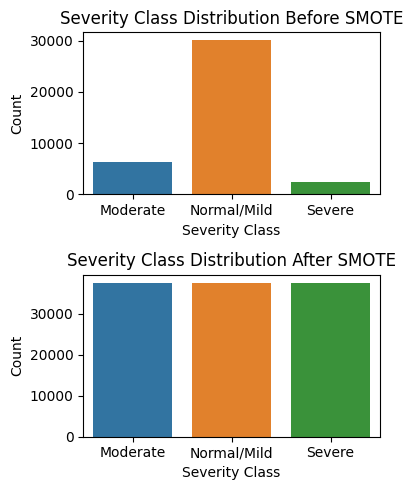

Original Image Count: 38925
SMOTE Image Count: severity
Moderate       37626
Normal/Mild    37626
Severe         37626
Name: count, dtype: int64


In [26]:
# Drop NaN values from both X and y simultaneously
df_final_cleaned = df_final.dropna(subset=['x', 'y', 'condition', 'level', 'severity'])

# Ensure X and y are aligned
X = df_final_cleaned[['x', 'y', 'condition', 'level']]
y = df_final_cleaned['severity']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps
numerical_features = ['x', 'y']
categorical_features = ['condition', 'level']

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# Apply preprocessing on training and test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Apply SMOTE on training data only
smote_strategy = {'Normal/Mild': 37626, 'Moderate': 37626, 'Severe': 37626}
smote = SMOTE(sampling_strategy=smote_strategy, random_state=42)

# Fit and resample using SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

# Count occurrences of each severity class before SMOTE
severity_counts_before = y_train.value_counts().sort_index()

# Count occurrences of each severity class after SMOTE
severity_counts_after = pd.Series(y_train_resampled).value_counts().sort_index()

# Plotting
plt.figure(figsize=(4, 5))

# Subplot 1: Severity counts before SMOTEa
plt.subplot(2, 1, 1)
sns.barplot(x=severity_counts_before.index, y=severity_counts_before.values)
plt.title('Severity Class Distribution Before SMOTE')
plt.xlabel('Severity Class')
plt.ylabel('Count')

# Subplot 2: Severity counts after SMOTE
plt.subplot(2, 1, 2)
sns.barplot(x=severity_counts_after.index, y=severity_counts_after.values)
plt.title('Severity Class Distribution After SMOTE')
plt.xlabel('Severity Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()
augmented_image_count = X_train_resampled.shape[0]
original_image_count = X_train_preprocessed.shape[0]


print(f"Original Image Count: {original_image_count}")
print(f"SMOTE Image Count: {severity_counts_after}")

In [28]:
import pandas as pd
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE

# Load your datasets
df_train = pd.read_csv("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv")
df_train_desc = pd.read_csv("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv")
df_train_desc['image_path'] = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/" + df_train_desc['study_id'].astype(str) + "/" + df_train_desc['series_id'].astype(str) + "/" + df_train_desc['instance_number'].astype(str) + ".dcm"

# Reshape the training DataFrame
df_train_melted = df_train.melt(id_vars=['study_id'], var_name='condition_level', value_name='severity')

# Extract 'condition' and 'level' from 'condition_level'
df_train_melted[['conditions', 'level']] = df_train_melted['condition_level'].str.rsplit('_', n=2, expand=True).iloc[:, 1:]
df_train_melted['condition'] = df_train_melted['condition_level'].apply(lambda x: '_'.join(x.split('_')[:-2])).str.replace("_", " ").str.title()
df_train_melted['level'] = df_train_melted['conditions'].str.upper() + "/" + df_train_melted['level'].str.upper()

# Drop unnecessary columns
df_train_melted = df_train_melted.drop(columns=['condition_level', 'conditions'])

# Merge the DataFrames on 'study_id', 'level', and 'condition'
df_final = pd.merge(df_train_desc, df_train_melted, on=['study_id', 'level', 'condition'], how='inner')

# Drop NaN values from both X and y simultaneously
df_final_cleaned = df_final.dropna(subset=['x', 'y', 'condition', 'level', 'severity'])

# Ensure X and y are aligned
X = df_final_cleaned[['x', 'y', 'condition', 'level']]
y = df_final_cleaned['severity']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps
numerical_features = ['x', 'y']
categorical_features = ['condition', 'level']

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# Apply preprocessing on training and test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Apply SMOTE on training data only
smote_strategy = {'Normal/Mild': 37626, 'Moderate': 37626, 'Severe': 37626}
smote = SMOTE(sampling_strategy=smote_strategy, random_state=42)

# Fit and resample using SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)


In [29]:
# Directory containing all images
image_dir = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/"

# Get all image paths in the directory
all_image_paths = glob.glob(os.path.join(image_dir, '**', '*.dcm'), recursive=True)

# Convert to a set for faster lookup
annotated_image_paths = set(df_train_desc['image_path'].tolist())

# Identify unannotated images
unannotated_image_paths = [path for path in all_image_paths if path not in annotated_image_paths]

print(f"Total annotated images: {len(annotated_image_paths)}")
print(f"Total unannotated images: {len(unannotated_image_paths)}")


Total annotated images: 24546
Total unannotated images: 122672


In [31]:
import numpy as np
import pydicom
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image

def load_dicom_image(file_path, target_size=(128, 128)):
    dicom = pydicom.dcmread(file_path)
    image = dicom.pixel_array
    image = np.stack([image] * 3, axis=-1)  # convert to RGB
    image = np.clip(image, 0, np.max(image))
    image = image / np.max(image)  # normalize
    image = np.array(image, dtype=np.float32)
    image = np.array(Image.fromarray(image.astype('uint8')).resize(target_size))
    return image

# Load and preprocess images
unlabeled_images = [load_dicom_image(path) for path in unannotated_image_paths]
X_unlabeled_images = np.stack(unlabeled_images)


KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer

def create_cnn_model(input_shape):
    model = Sequential([
        InputLayer(input_shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (128, 128, 3)
model = create_cnn_model(input_shape)


In [ ]:
from sklearn.semi_supervised import SelfTrainingClassifier

# Define a wrapper to use Keras model with scikit-learn
class KerasWrapper(tf.keras.wrappers.scikit_learn.KerasClassifier):
    def predict(self, X):
        pred = super().predict(X)
        return np.argmax(pred, axis=1)
    
    def predict_proba(self, X):
        return super().predict(X)

base_classifier = KerasWrapper(build_fn=create_cnn_model, input_shape=input_shape)
self_training_clf = SelfTrainingClassifier(base_classifier, criterion='k_nearest_neighbors')

# Convert y_train_resampled to categorical format
y_train_resampled_cat = to_categorical(y_train_resampled.map({'Normal/Mild': 0, 'Moderate': 1, 'Severe': 2}))

# Fit the self-training model on the labeled data
self_training_clf.fit(X_train_resampled, np.argmax(y_train_resampled_cat, axis=1))

# Predict on the unlabeled data
y_unlabeled_pred = self_training_clf.predict(X_unlabeled_images)

# Combine labeled and newly labeled data
X_combined = np.vstack((X_train_resampled, X_unlabeled_images))
y_combined = to_categorical(np.concatenate((np.argmax(y_train_resampled_cat, axis=1), y_unlabeled_pred)))

# Train a final model on the combined data
final_model = create_cnn_model(input_shape)
final_model.fit(X_combined, y_combined, epochs=5, batch_size=128, validation_split=0.2)

In [ ]:
# Load and preprocess test images
X_test_images = [load_dicom_image(path) for path in df_test_cleaned['image_path']]
X_test_images = np.stack(X_test_images)

# Evaluate the model
test_loss, test_acc = final_model.evaluate(X_test_images, y_test)
print(f"Test Accuracy: {test_acc:.4f}")